In [156]:
import numpy as np
import pandas as pd
import xgboost as xgb
import re
import sklearn
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import (RandomForestClassifier ,AdaBoostClassifier, 
                             GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold


In [141]:
train = pd.read_csv(r"C:\Users\admin\Downloads\titanic\train.csv")
test = pd.read_csv(r"C:\Users\admin\Downloads\titanic\test.csv")
user  = test["PassengerId"]

In [142]:
test.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [143]:
all_data = [train, test]

In [144]:
for data_set in all_data:
    data_set["Name_length"] = data_set["Name"].apply(len)
    data_set["Has_Cabin"] = data_set["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    data_set["FamilySize"] = data_set["SibSp"] + data_set["Parch"] + 1
    data_set["IsAlone"] = 0
    data_set.loc[data_set["FamilySize"] == 1, "IsAlone"] = 1
    data_set["Embarked"] = data_set["Embarked"].fillna("S")
    data_set["Fare"] = data_set["Fare"].fillna(train["Fare"].median())
train["CategoricalFare"] = pd.qcut(train["Fare"], 4)


# Pandas Tips

1. pandas可以用apply(),类似于scala中的map()函数： 
                                               data["slice"].apply(lambda x: x+1);
2. pandas可以用map(),用于映射转换：
                                               data["slcie"].map({"a":"b"});
3. pandas中的qcut()可以用于快速进行类别标签：
                                               pd.qcut([1,2,3,4], 4);

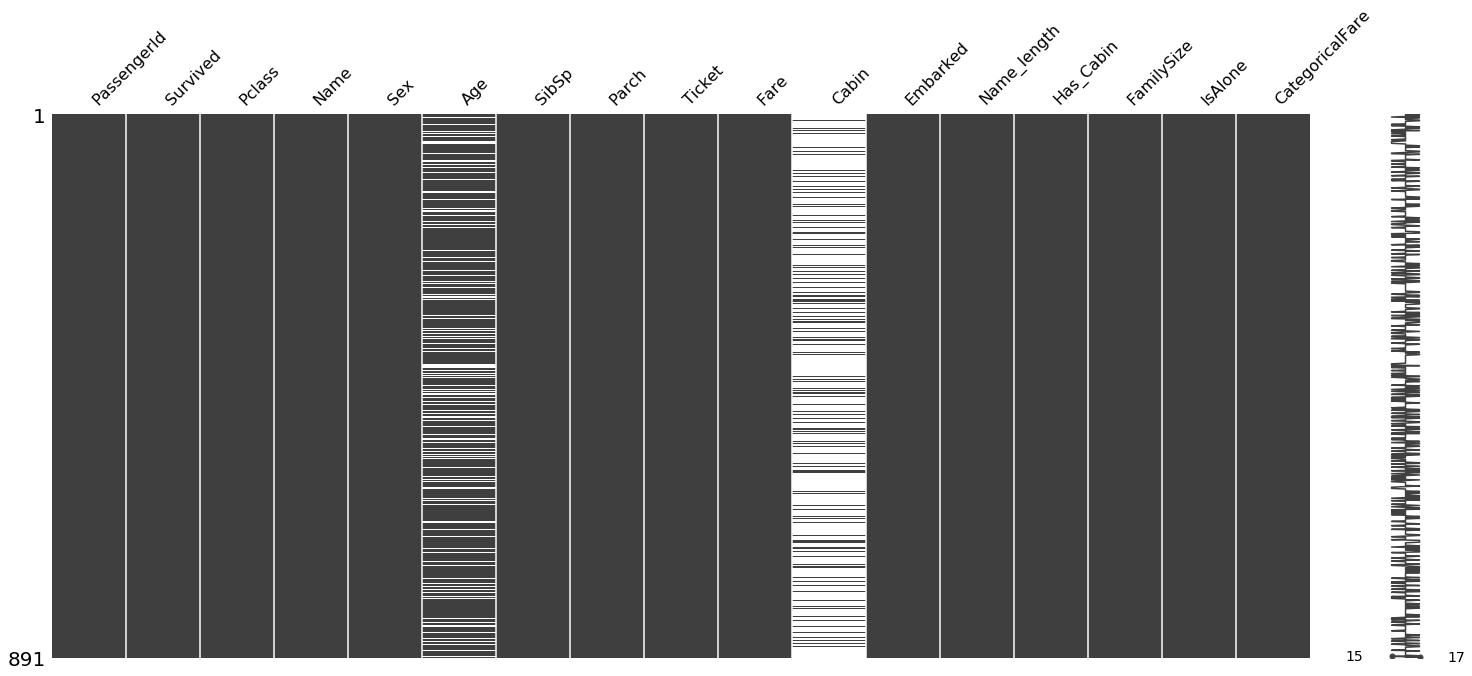

In [145]:
msno.matrix(train)

In [146]:
for data_set in all_data:
    age_avg = data_set["Age"].mean()
    age_std = data_set["Age"].std()
    age_null_count = data_set["Age"].isnull().sum()
    age_null_random = np.random.randint(age_avg-age_std, age_avg+age_std, size=age_null_count)
    data_set["Age"][np.isnan(data_set["Age"])] = age_null_random
    data_set["Age_class"] = pd.cut(data_set["Age"], 5)

E:\swtx\annoconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\swtx\annoconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [147]:
def get_title(name):
    sech = re.search(r"([A-Za-z]+)\.", name)
    if sech:
        return sech.group(1)
    return ""

for data_set in all_data:
    data_set["Title"] = data_set["Name"].apply(get_title)
    data_set["Title"] = data_set["Title"].replace(["Lady", "Countess", "Capy","Col","Don","Dr","Major","Rev",'Sir', 'Jonkheer', 'Dona'],"Rare")
    data_set['Title'] = data_set["Title"].replace("Ms", "Miss")
    data_set['Title'] = data_set["Title"].replace("Mme", "Mrs")
    data_set["Sex"] = data_set["Sex"].map({"female":0, "male":1}).astype(int)
    title_dcit = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    data_set["Title"] = data_set["Title"].map(title_dcit)
    data_set["Title"] = data_set["Title"].fillna(0)
    data_set['Embarked'] = data_set['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)
    data_set.loc[ data_set['Fare'] <= 7.91, 'Fare'] = 0
    data_set.loc[(data_set['Fare'] > 7.91) & (data_set['Fare'] <= 14.454), 'Fare'] = 1
    data_set.loc[(data_set['Fare'] > 14.454) & (data_set['Fare'] <= 31), 'Fare'] = 2
    data_set.loc[ data_set['Fare'] > 31, 'Fare'] = 3 
    data_set.loc[ data_set['Age'] > 64, 'Age'] = 4 

In [148]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['Age_class', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [154]:
train.describe()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,28.789753,0.381594,1.505051,0.361392,26.965208,0.228956,1.904602,0.602694,1.718294
std,0.486592,0.836071,0.477990,12.988109,0.806057,1.118148,0.635673,9.281607,0.420397,1.613459,0.489615,1.028958
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,12.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.750000,0.000000,0.500000,0.000000,20.000000,0.000000,1.000000,0.000000,1.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,2.000000,0.000000,25.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,3.000000,1.000000,36.250000,0.000000,2.000000,1.000000,30.000000,0.000000,2.000000,1.000000,2.000000
max,1.000000,3.000000,1.000000,64.000000,6.000000,3.000000,2.000000,82.000000,1.000000,11.000000,1.000000,5.000000


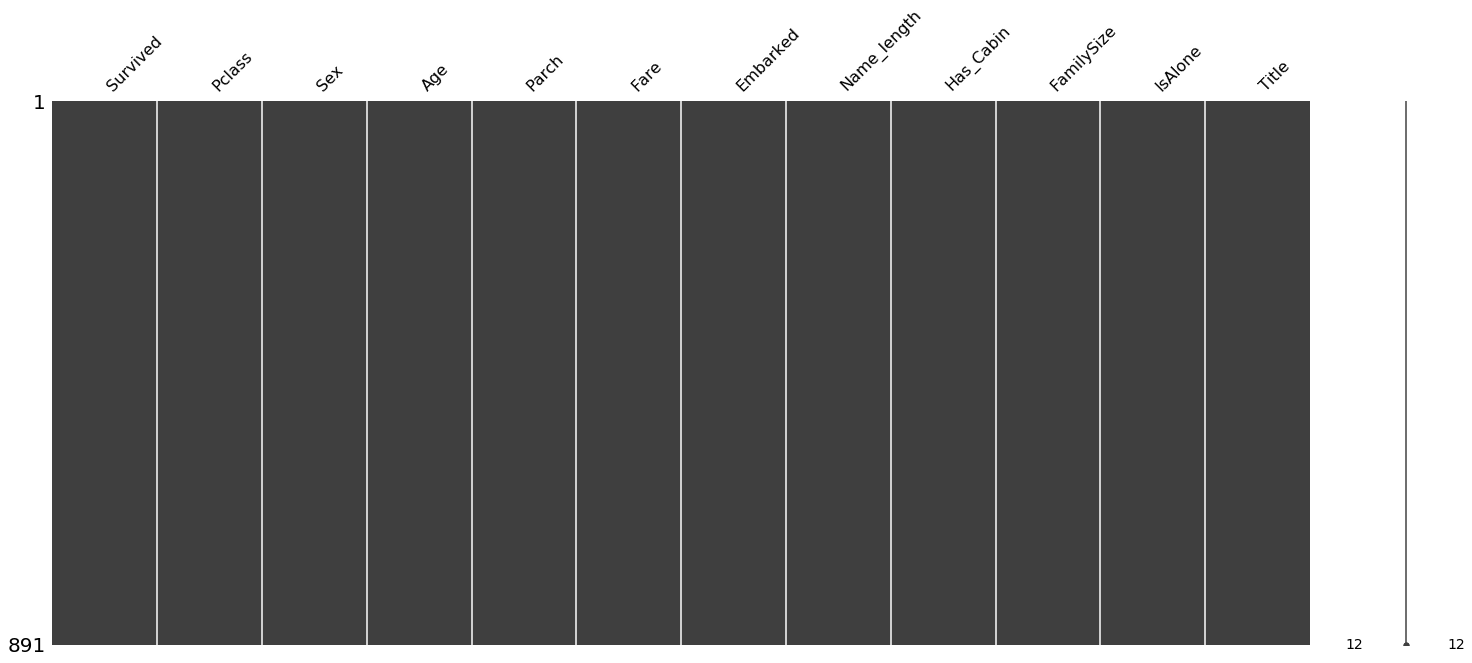

In [150]:
msno.matrix(train)

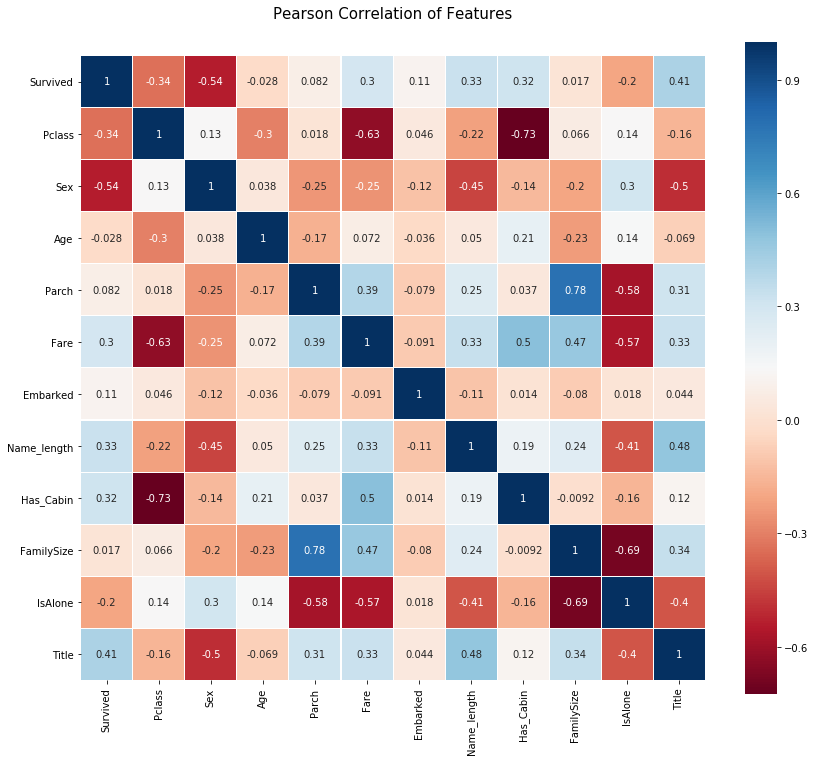

In [158]:
# 就是线条颜色
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)